# Code

## Get Data

In [223]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import threading
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification
import copy

In [224]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_test = X[900:]
y_test = y[900:]
X = X[:900]
y = y[:900]


print(f"X shape: {X_test.shape}")
print(f"y shape: {y_test.shape}")

X shape: (100, 2)
y shape: (100,)


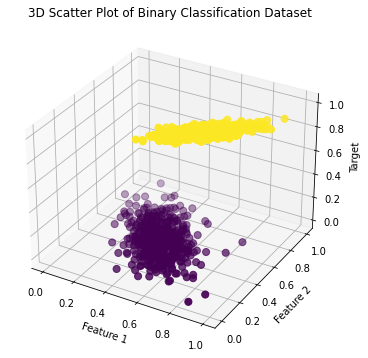

In [225]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

feature1 = X[:, 0]
feature2 = X[:, 1]
ax.scatter(feature1, feature2, y, c=y, cmap='viridis', s=50)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')

plt.title('3D Scatter Plot of Binary Classification Dataset')
plt.show()

## Classes

In [226]:
class Model(nn.Module):
    def __init__(self, input_shape):
        super(Model, self).__init__()
        self.input_shape = input_shape
        self.layer1 = nn.Linear(input_shape[0], 5, bias=True)
        self.layer2 = nn.Linear(5, 16, bias=True)
        self.layer3 = nn.Linear(16, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        x = self.layer3(x)

        return x

In [196]:
class Node(threading.Thread):
    num_epochs = 10
    batch_size = 64
    lr = 0.001

    def __init__(self, model, X, y, central):
        super().__init__()
        self.barrier = None
        self.model = model
        self.central = central
        self.train_loader = self.preparData(X, y)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.gradient = None
        self.avg_loss = None

    def preparData(self, X, y):
        y = y.reshape((y.shape[0], 1))
        X = torch.tensor(X)
        y = torch.tensor(y)
        X = X.float()
        y = y.float()
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return data_loader

    def run(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0
            lock = threading.Lock()
            for inputs, targets in self.train_loader:
                self.optimizer.zero_grad()  
                outputs = self.model(inputs)  
                loss = self.criterion(outputs, targets)  
                loss.backward() 
                self.central.w_gradient.append([param.grad.clone() for param in self.model.parameters()])
                print(f"I'm {self.name}")
                with lock:
                    self.central.update()
                    print("batch finished!")
                #self.barrier.wait()
                #self.central.update()
                
                total_loss += loss.item()

                self.avg_loss = total_loss / len(self.train_loader)
                print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {self.avg_loss}")
        
    def count_loss(self, loader):
        total_loss = 0.0

        for inputs, targets in loader: 
            outputs = self.model(inputs)  
            loss = self.criterion(outputs, targets)  
            total_loss += loss.item()
            
        self.avg_loss = total_loss / len(loader)

In [197]:
class Central(Node):
    def __init__(self, num_workers, model, X, y):
        super(Central, self).__init__(model, X, y, self) #model is here
        self.num_workers = num_workers
        self.model = model
        #self.century = century
        self.dataset = self.devideData(X, y)
        self.barrier = threading.Barrier(self.num_workers)
        self.workers = [Node(copy.deepcopy(self.model), self.dataset[0][i], self.dataset[1][i], self) for i in range(num_workers)]
        for worker in self.workers:
            worker.barrier = self.barrier
        self.w_gradient = []
    
    def devideData(self, X, y):
        l_x = []
        l_y = []
        for i in range(self.num_workers):
            l_x.append(X[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
            l_y.append(y[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
        return l_x, l_y
    
    
    def update(self):
        gradient = []
        for i in range(len(list(self.workers[0].model.parameters()))):
            elem = 0
            for grad in self.w_gradient:
                elem += grad[i]
            gradient.append(elem)
        
        with torch.no_grad():
            for param, grad in zip(self.model.parameters(), gradient):
                param -= self.lr * grad
        
        for worker in self.workers:
            with torch.no_grad():
                for param_src, param_dst in zip(self.model.parameters(), worker.model.parameters()):
                    param_dst.copy_(param_src)


In [227]:
model = Model(input_shape=(2,))

In [215]:
central = Central(1, model, X, y)

In [216]:
for e, worker in enumerate(central.workers):
    worker.run()
    print(f"\n --> The worker{e+1} was finished!\n")

I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.01653734644254049
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.03308132092158
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.0496349573135376
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.06563375095526378
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.08165659606456757
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.09803064167499542
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.11447870632012686
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.1307470013697942
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.14687471389770507
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.16323463122049967
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.1797734518845876
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.19613356391588846
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.21225273311138154
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.22850622236728668
I'm Thread-96
batch finished!
Epoch 1/10, Loss: 0.2456


Epoch 2/10, Loss: 0.16147751112778982
I'm Thread-96
batch finished!
Epoch 2/10, Loss: 0.17722628116607667
I'm Thread-96
batch finished!
Epoch 2/10, Loss: 0.1933558682600657
I'm Thread-96
batch finished!
Epoch 2/10, Loss: 0.21010087331136068
I'm Thread-96
batch finished!
Epoch 2/10, Loss: 0.22627522746721904
I'm Thread-96
batch finished!
Epoch 2/10, Loss: 0.24359919826189677
I'm Thread-96
batch finished!
Epoch 3/10, Loss: 0.0164037028948466
I'm Thread-96
batch finished!
Epoch 3/10, Loss: 0.032725405693054196
I'm Thread-96
batch finished!
Epoch 3/10, Loss: 0.04836986462275187
I'm Thread-96
batch finished!
Epoch 3/10, Loss: 0.06439769466718039
I'm Thread-96
batch finished!
Epoch 3/10, Loss: 0.08081858158111573
I'm Thread-96
batch finished!
Epoch 3/10, Loss: 0.09686881303787231
I'm Thread-96
batch finished!
Epoch 3/10, Loss: 0.11283275087674459
I'm Thread-96
batch finished!
Epoch 3/10, Loss: 0.12867249846458434
I'm Thread-96
batch finished!
Epoch 3/10, Loss: 0.14439599911371867
I'm Thread

In [217]:
test_loader = central.preparData(X_test, y_test)

In [218]:
for worker in central.workers:
    worker.count_loss(test_loader)

In [219]:
for worker in central.workers:
    print(worker.avg_loss)

0.17695046216249466


In [220]:
central.count_loss(test_loader)

In [221]:
central.avg_loss

0.16269397735595703

In [ ]:
from tensorflow.keras.datasets import mnist


In [236]:
model = Model(input_shape=(2,))

In [237]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()


y = y.reshape((y.shape[0], 1))
X = torch.tensor(X)
y = torch.tensor(y)
X = X.float()
y = y.float()
dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

for epoch in range(10):
    model.train()
    total_loss = 0.0
    for inputs, targets in data_loader:
        optimizer.zero_grad()  
        outputs = model(inputs)  
        loss = criterion(outputs, targets)  
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{10}, Loss: {avg_loss}")


C:\Users\etabook\AppData\Local\Temp\ipykernel_15756\1180281956.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
C:\Users\etabook\AppData\Local\Temp\ipykernel_15756\1180281956.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


Epoch 1/10, Loss: 0.09266385237375895
Epoch 1/10, Loss: 0.18259791533152261
Epoch 1/10, Loss: 0.2528393268585205
Epoch 1/10, Loss: 0.33617310523986815
Epoch 1/10, Loss: 0.4127012809117635
Epoch 1/10, Loss: 0.49833041032155356
Epoch 1/10, Loss: 0.5825069348017374
Epoch 1/10, Loss: 0.6593552112579346
Epoch 1/10, Loss: 0.7730370601018269
Epoch 1/10, Loss: 0.8642211119333904
Epoch 1/10, Loss: 0.9490185419718424
Epoch 1/10, Loss: 1.0488883574803671
Epoch 1/10, Loss: 1.1236327012379965
Epoch 1/10, Loss: 1.2166134039560954
Epoch 1/10, Loss: 1.2301397035519281
Epoch 2/10, Loss: 0.09037674268086751
Epoch 2/10, Loss: 0.1686235745747884
Epoch 2/10, Loss: 0.2569221655527751
Epoch 2/10, Loss: 0.35006511211395264
Epoch 2/10, Loss: 0.42449764410654706
Epoch 2/10, Loss: 0.5004689931869507
Epoch 2/10, Loss: 0.5926925738652548
Epoch 2/10, Loss: 0.668972643216451
Epoch 2/10, Loss: 0.7442365010579427
Epoch 2/10, Loss: 0.8206495443979899
Epoch 2/10, Loss: 0.9143735567728678
Epoch 2/10, Loss: 0.994132328033

Epoch 3/10, Loss: 0.26509416898091637
Epoch 3/10, Loss: 0.34344175656636555
Epoch 3/10, Loss: 0.4392116626103719
Epoch 3/10, Loss: 0.5212801059087118
Epoch 3/10, Loss: 0.6013707081476848
Epoch 3/10, Loss: 0.6701440970102946
Epoch 3/10, Loss: 0.7465287526448567
Epoch 3/10, Loss: 0.8259338935216268
Epoch 3/10, Loss: 0.9039068460464478
Epoch 3/10, Loss: 0.9988711516062418
Epoch 3/10, Loss: 1.0839250882466633
Epoch 3/10, Loss: 1.1429232676823935
Epoch 3/10, Loss: 1.2572156031926474
Epoch 4/10, Loss: 0.07953975995381674
Epoch 4/10, Loss: 0.1404530922571818
Epoch 4/10, Loss: 0.22374942302703857
Epoch 4/10, Loss: 0.30477868715922035
Epoch 4/10, Loss: 0.39095853169759115
Epoch 4/10, Loss: 0.47520796457926434
Epoch 4/10, Loss: 0.5608758767445882
Epoch 4/10, Loss: 0.6387635707855225
Epoch 4/10, Loss: 0.718782901763916
Epoch 4/10, Loss: 0.7906885623931885
Epoch 4/10, Loss: 0.868467386563619
Epoch 4/10, Loss: 0.9476569016774495
Epoch 4/10, Loss: 1.0306887785593668
Epoch 4/10, Loss: 1.1142141819000